In [32]:
# Blake Zurman
# HW 3 Imputation Evaluation
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore

train_df = pd.read_csv('hw-3-train-data.csv')
test_df = pd.read_csv('hw-3-test-data.csv')
og_train_df = train_df.copy()
og_test_df = test_df.copy()

In [34]:
# EDA

# Generate summary statistics for numerical columns in train_df to understand feature distribution and range.
# Check for missing values in train_df; none found according to initial inspection.
# Display first few rows of train_df to observe structure (commented out).
# Pairplot (commented) would show feature relationships in og_train_df for visual exploration.
# Plot histograms of numerical columns to assess distributions and detect potential skewness or outliers.
# Countplot (commented) would reveal class distribution of target variable 'y' to check for imbalance.
# Notes: 'balance' needs scaling; outliers are acceptable in 'balance' but 'previous' contains a notable outlier.

#print(train_df.info())
print(train_df.describe())
print(train_df.isnull().sum()) # I don't see any in the training data
#train_df.head()

#sns.pairplot(og_train_df)
#plt.show()

#train_df.hist(bins=30, figsize=(15, 10))
#plt.show()

# 'balance' needs scaled, outliers in 'balance' seem ok
# outlier in 'previous'

#sns.countplot(x='y', data=og_train_df)
#plt.title('Class Distribution')
#plt.show()


                age        balance           day      campaign         pdays  \
count  44211.000000   44211.000000  44211.000000  44211.000000  44211.000000   
mean      40.930040    1363.799462     15.811676      2.762751     40.210626   
std       10.620088    3052.574757      8.324843      3.094049    100.114045   
min       18.000000   -8019.000000      1.000000      1.000000     -1.000000   
25%       33.000000      72.000000      8.000000      1.000000     -1.000000   
50%       39.000000     448.000000     16.000000      2.000000     -1.000000   
75%       48.000000    1430.000000     21.000000      3.000000     -1.000000   
max       95.000000  102127.000000     31.000000     58.000000    871.000000   

           previous  
count  44211.000000  
mean       0.580715  
std        2.311291  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max      275.000000  
age          0
job          0
marital      0
education    0
default      0
balanc

In [37]:
# One of my findings was that there was a huge outlier, and the rest of the values seemed to be ok. 
## This certainly seems to be an outlier
max_value = train_df["previous"].max()
max_index = train_df["previous"].idxmax()

print(max_value)

# second highest
second_highest = train_df["previous"].sort_values(ascending=False).iloc[1]
print(second_highest)

275
58


In [39]:
# ONLY RUN ONCE
# This handles that one value and then checks i did it right
# Impute the maximum value with the calculated average
average_value = train_df[train_df["previous"] != max_value]["previous"].mean()
train_df.at[max_index, "previous"] = average_value

max_value2 = train_df["previous"].max()
print(max_value2)

58.0


/var/folders/_3/l3p32sr93qxcl98qdj6_4pg40000gn/T/ipykernel_31257/3586208858.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5745080298574983' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_df.at[max_index, "previous"] = average_value


In [ ]:
# Below I included all the functions I made in order to clean this data.
# I reused some of them, created some, and modified some
# These functions will clean the training data, and will give me the ability to clean the test data the exact same way
# I chose many types of scalers because I ran into a lot of issues with the scales of the data
# Columns needed scaling, but they had 0s and negative numbers, so i couldn't just log scale
# I tried box cox as a result

In [41]:
import numpy as np

'''
    LOG SCALER FUNCTION
    Input: df and target columns
    Applies a log transformation
    Handles zero by adding a small constant to avoid log(0)
'''
def log_scale_columns(df, columns_to_scale, epsilon=1e-6):
    # Apply log transformation to each specified column, adding epsilon to handle zeros
    df[columns_to_scale] = df[columns_to_scale].apply(lambda x: np.log(x + epsilon))
    
    return df

In [43]:
import numpy as np
import pandas as pd
from scipy import stats

'''
    BOX-COX SCALER FUNCTION
    Input: df and target columns
    Applies Box-Cox transformation
    Shifts the data if necessary to make all values positive
'''

def boxcox_scale_columns(df, columns_to_scale):
    # Shift the data if necessary to ensure all values are positive
    for col in columns_to_scale:
        # If the minimum value in the column is less than or equal to 0, shift all values
        min_value = df[col].min()
        if min_value <= 0:
            shift_value = abs(min_value) + 1  # Shift to make all values positive
            df[col] = df[col] + shift_value

        # Apply Box-Cox transformation
        df[col], _ = stats.boxcox(df[col])

    return df

In [45]:
from sklearn.preprocessing import StandardScaler
# scaler funct
'''
    SCALER FUNCTION
    Input df and target columns
    uses standard scaler
'''
def scale_columns(df, columns_to_scale):
    # Create a scaler instance
    scaler = StandardScaler()
    
    # Fit and transform only the specified columns
    df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
    
    return df

In [47]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
'''
    LABEL ENCODING FUNCTION
    Input df and target columns
    Function label encodes the columns
'''
def label_encode_columns(df, columns):
    label_encoder = LabelEncoder()
    
    for column in columns:
        if column in df.columns:
            # Perform label encoding
            df[column] = label_encoder.fit_transform(df[column])
        else:
            print(f"Warning: Column '{column}' not found in the DataFrame.")
    
    return df

In [49]:
import pandas as pd
'''
    ONE-HOT ENCODING FUNCTION
    Input df and target columns
    Function performs one-hot encoding on the columns
'''

def one_hot_encode_columns(df, columns):
    for column in columns:
        if column in df.columns:
            # Perform one-hot encoding
            df = pd.get_dummies(df, columns=[column], prefix=[column], drop_first=False)
        else:
            print(f"Warning: Column '{column}' not found in the DataFrame.")
    
    return df


In [51]:
def convert_yes_no_to_binary_multiple(df, column_names):
    """
    Converts 'yes' and 'no' values in the specified columns of the dataframe to binary (1 for 'yes', 0 for 'no').
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    column_names (list): A list of column names to apply the conversion to.
    
    Returns:
    pd.DataFrame: DataFrame with the specified columns converted to binary.
    """
    for column in column_names:
        df[column] = df[column].map({'yes': 1, 'no': 0})
    return df

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


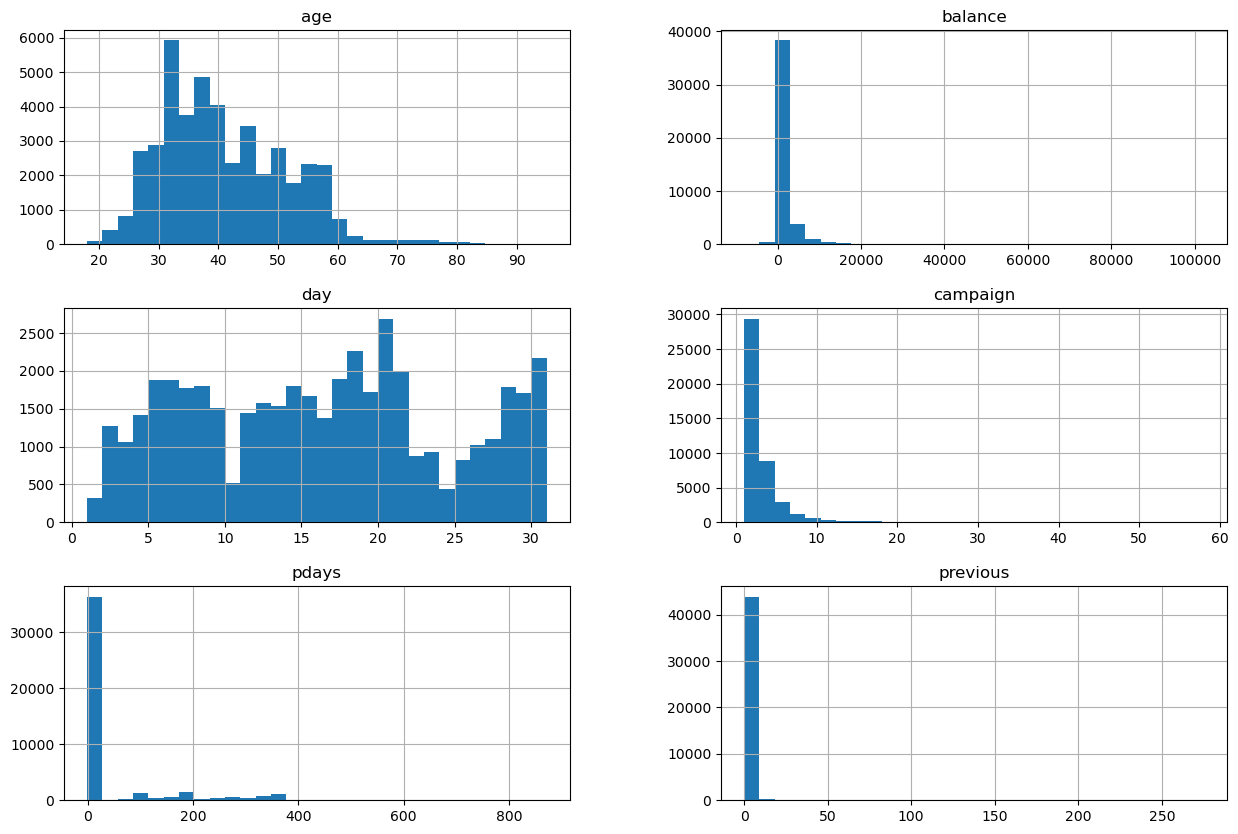

In [53]:
# LOG SCALING CAMPAIGN AND PREVIOUS
print(train_df.isnull().sum())
train_df_scaled = log_scale_columns(train_df, ["campaign", "previous"])
print(train_df_scaled.isnull().sum())
og_train_df.hist(bins=30, figsize=(15, 10))
plt.show()

In [55]:
# boxcox Scaling
#features
columns_to_scale = ['age', 'balance', 'pdays']
# Scale the specified columns
train_df_scaled = boxcox_scale_columns(train_df_scaled, columns_to_scale)

In [57]:
print(train_df_scaled.isnull().sum())

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


In [59]:
# ONE-HOT ENCODING
# These seem to be columns that need encoding but are not ordinal
# 1. job
# 2. marital
# 3. contact
# 4. month
# 5. poutcome

train_df_encoded = one_hot_encode_columns(train_df_scaled, ['job', 'marital', 'contact', 'month', 'poutcome'])
# print(train_df_encoded)

In [61]:
# LABEL ENCODING
# The only ordinal column
# 1. Education

train_df_encoded = label_encode_columns(train_df_encoded, ['education'])
# print(train_df_encoded)

In [63]:
# BINARY CONVERSION
# did this to turn the yes and nos into a number

train_df_encoded = convert_yes_no_to_binary_multiple(train_df_encoded, ['default', 'housing', 'loan'])
print(train_df_encoded)

            age  education  default   balance  housing  loan  day  \
0      2.961609          2        0  7.773171        1     0    5   
1      2.816723          1        0  7.608623        1     0    5   
2      2.658676          1        0  7.606242        1     1    5   
3      2.851916          3        0  7.727646        1     0    5   
4      2.658676          3        0  7.606153        0     0    5   
...         ...        ...      ...       ...      ...   ...  ...   
44206  2.894972          2        0  7.675341        0     0   17   
44207  3.063577          0        0  7.743934        0     0   17   
44208  3.070504          1        0  7.983527        0     0   17   
44209  2.952680          1        0  7.662689        0     0   17   
44210  2.722428          1        0  7.828106        0     0   17   

           campaign     pdays   previous  ... month_jun  month_mar  month_may  \
0      9.999995e-07  0.000000 -13.815511  ...     False      False       True   
1      9.

In [65]:
# LABEL THE CLEAN DATA SET
train_df_clean = train_df_encoded

train_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44211 entries, 0 to 44210
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                44211 non-null  float64
 1   education          44211 non-null  int64  
 2   default            44211 non-null  int64  
 3   balance            44211 non-null  float64
 4   housing            44211 non-null  int64  
 5   loan               44211 non-null  int64  
 6   day                44211 non-null  int64  
 7   campaign           44211 non-null  float64
 8   pdays              44211 non-null  float64
 9   previous           44211 non-null  float64
 10  y                  44211 non-null  object 
 11  job_admin.         44211 non-null  bool   
 12  job_blue-collar    44211 non-null  bool   
 13  job_entrepreneur   44211 non-null  bool   
 14  job_housemaid      44211 non-null  bool   
 15  job_management     44211 non-null  bool   
 16  job_retired        442

In [183]:
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, f1_score
from sklearn.feature_selection import RFE

'''
    Function to compare classification models
    input train_df_clean and target column
    with feature selection using RFE
'''
def evaluate_classifiers(train_df_clean, target_column='y'):
    # Define features (X) and target (y)
    X = train_df_clean.drop(columns=[target_column])
    y = train_df_clean[target_column]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define classifiers
    classifiers = {
        'Logistic Regression': LogisticRegression(class_weight='balanced'),
        #'Random Forest': RandomForestClassifier(),
        #'SVM': SVC(class_weight='balanced', probability=True),
        #'KNN': KNeighborsClassifier(),
        #'SGD Classifier': SGDClassifier()
    }

    # F1 scorer for cross-validation
    f1_scorer = make_scorer(f1_score, pos_label='yes')
    accuracy_scorer = make_scorer(f1_score, pos_label='yes')

    # Initialize results dictionary
    results = {}

    # Feature Selection using RFE with Logistic Regression
    rfe = RFE(estimator=LogisticRegression(), n_features_to_select=44)  # Adjust n_features_to_select based on the data

    # Evaluate each classifier with feature selection
    for name, clf in classifiers.items():
        # Apply RFE to select important features
        X_train_selected = rfe.fit_transform(X_train, y_train)
        
        # Perform cross-validation for F1 score and accuracy
        f1_scores = cross_val_score(clf, X_train_selected, y_train, cv=5, scoring=f1_scorer)
        accuracy_scores = cross_val_score(clf, X_train_selected, y_train, cv=5, scoring='accuracy')
        
        # Store the mean of each metric
        results[name] = {
            'F1-Score': f1_scores.mean(),
            'Accuracy': accuracy_scores.mean(),
            'Selected Features': list(X_train.columns[rfe.support_])  # List of selected features
        }

    # Print the results
    for name, scores in results.items():
        print(f"{name} - Mean F1-Score: {scores['F1-Score']:.4f}, Mean Accuracy: {scores['Accuracy']:.4f}")
        print(f"Selected Features: {', '.join(scores['Selected Features'])}")

    return results

# Example usage
evaluate_classifiers(train_df_clean, target_column='y')


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

Logistic Regression - Mean F1-Score: 0.3783, Mean Accuracy: 0.7537
Selected Features: age, education, default, balance, housing, loan, day, campaign, pdays, previous, job_admin., job_blue-collar, job_entrepreneur, job_housemaid, job_management, job_retired, job_self-employed, job_services, job_student, job_technician, job_unemployed, job_unknown, marital_divorced, marital_married, marital_single, contact_cellular, contact_telephone, contact_unknown, month_apr, month_aug, month_dec, month_feb, month_jan, month_jul, month_jun, month_mar, month_may, month_nov, month_oct, month_sep, poutcome_failure, poutcome_other, poutcome_success, poutcome_unknown


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'Logistic Regression': {'F1-Score': 0.3782969831350891,
  'Accuracy': 0.75367606072318,
  'Selected Features': ['age',
   'education',
   'default',
   'balance',
   'housing',
   'loan',
   'day',
   'campaign',
   'pdays',
   'previous',
   'job_admin.',
   'job_blue-collar',
   'job_entrepreneur',
   'job_housemaid',
   'job_management',
   'job_retired',
   'job_self-employed',
   'job_services',
   'job_student',
   'job_technician',
   'job_unemployed',
   'job_unknown',
   'marital_divorced',
   'marital_married',
   'marital_single',
   'contact_cellular',
   'contact_telephone',
   'contact_unknown',
   'month_apr',
   'month_aug',
   'month_dec',
   'month_feb',
   'month_jan',
   'month_jul',
   'month_jun',
   'month_mar',
   'month_may',
   'month_nov',
   'month_oct',
   'month_sep',
   'poutcome_failure',
   'poutcome_other',
   'poutcome_success',
   'poutcome_unknown']}}

In [ ]:
# Above is the block of code that runs some classifiers and does cross evaluation.
# I had some trouble trying SVM because I think I have way too much data for my computer to handle
# Unfortunately, below are the best results (F1 score) I could get with each classifier... not very good
# Logistic seemed to be the best by just a hair with a mediocre f1 score of .4
# I spent a lot of time trying to feature engineer with RFE to get the most relevant feaures, and I found that somewhere around the first
# 10-20 features of my 44 seem to give the best results
# This assignment caused me a lot of trouble I think because of the encoding. 
# There seems to be a weird statistical significance with some of the encoding values, which dominates the calculations.
# I think the only thing I could have done better was to more carefully encode and feature engineer. 

In [ ]:
'''
Random Forest - Mean F1-Score: 0.3372, Mean Accuracy: 0.8908
{'Random Forest': {'F1-Score': 0.3371921609387222,
  'Accuracy': 0.8908052783362935}}
'''

In [ ]:
# n = 15
'''
{'KNN': {'F1-Score': 0.3274272939033321,
  'Accuracy': 0.8708162395945094,
  'Selected Features': ['housing',
   'job_student',
   'contact_unknown',
   'month_aug',
   'month_feb',
   'month_jan',
   'month_jul',
   'month_mar',
   'month_may',
   'month_nov',
   'month_oct',
   'month_sep',
   'poutcome_failure',
   'poutcome_success',
   'poutcome_unknown']}}
'''

In [ ]:
# n = 12
'''
Logistic Regression - Mean F1-Score: 0.4000, Mean Accuracy: 0.8124
Selected Features: housing, contact_unknown, month_aug, month_feb, month_jan, month_jul, month_mar, month_may, month_nov, month_oct, month_sep, poutcome_success
{'Logistic Regression': {'F1-Score': 0.40004685700558057,
  'Accuracy': 0.8124295119985646,
  'Selected Features': ['housing',
   'contact_unknown',
   'month_aug',
   'month_feb',
   'month_jan',
   'month_jul',
   'month_mar',
   'month_may',
   'month_nov',
   'month_oct',
   'month_sep',
   'poutcome_success']}}
'''

In [67]:
# CLEANING TEST DATA
test_df = pd.read_csv('hw-3-test-data.csv')

# Impute the maximum value with the calculated average
max_value = test_df["previous"].max()
max_index = test_df["previous"].idxmax()
average_value = test_df[test_df["previous"] != max_value]["previous"].mean()
test_df.at[max_index, "previous"] = average_value

# log scale
test_df_scaled = log_scale_columns(test_df, ["campaign", "previous"])

# boxcox Scaling
#features
columns_to_scale = ['age', 'balance', 'pdays']
# Scale the specified columns
test_df_scaled = boxcox_scale_columns(test_df_scaled, columns_to_scale)

# one hot
test_df_encoded = one_hot_encode_columns(test_df_scaled, ['job', 'marital', 'contact', 'month', 'poutcome'])

# label 
test_df_encoded = label_encode_columns(test_df_encoded, ['education'])

# binary
test_df_encoded = convert_yes_no_to_binary_multiple(test_df_encoded, ['default', 'housing', 'loan'])

# LABEL THE CLEAN DATA SET
test_df_clean = test_df_encoded

test_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 44 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                1000 non-null   float64
 1   education          1000 non-null   int64  
 2   default            1000 non-null   int64  
 3   balance            1000 non-null   float64
 4   housing            1000 non-null   int64  
 5   loan               1000 non-null   int64  
 6   day                1000 non-null   int64  
 7   campaign           1000 non-null   float64
 8   pdays              1000 non-null   float64
 9   previous           1000 non-null   float64
 10  job_admin.         1000 non-null   bool   
 11  job_blue-collar    1000 non-null   bool   
 12  job_entrepreneur   1000 non-null   bool   
 13  job_housemaid      1000 non-null   bool   
 14  job_management     1000 non-null   bool   
 15  job_retired        1000 non-null   bool   
 16  job_self-employed  1000 n

/var/folders/_3/l3p32sr93qxcl98qdj6_4pg40000gn/T/ipykernel_31257/23900367.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5385385385385385' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  test_df.at[max_index, "previous"] = average_value


In [69]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

'''
    Function to train classifier on train_df_clean and predict on test_df_clean
    Input: train_df_clean with target column, test_df_clean without target column
    Output: CSV file with predictions on test data
'''
def train_and_predict(train_df_clean, test_df_clean, target_column='y'):
    # Define features (X) and target (y) for training
    X_train = train_df_clean.drop(columns=[target_column])
    y_train = train_df_clean[target_column]

    # Initialize classifier
    classifier = LogisticRegression(class_weight='balanced')

    # Feature Selection using RFE with Logistic Regression
    rfe = RFE(estimator=classifier, n_features_to_select=12)  # Adjust based on the data

    # Fit RFE and transform the training set
    X_train_selected = rfe.fit_transform(X_train, y_train)
    
    # Fit the classifier on the selected features
    classifier.fit(X_train_selected, y_train)

    # Apply RFE on test data to select the same features
    X_test_selected = rfe.transform(test_df_clean)

    # Make predictions on the test data
    predictions = classifier.predict(X_test_selected)
    
    output_df = test_df_clean.copy()
    output_df['Predicted'] = predictions

    # Save
    output_df.to_csv('test_predictions.csv', index=False)
    print("Predictions saved to test_predictions.csv")


train_and_predict(train_df_clean, test_df_clean, target_column='y')


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

Predictions saved to test_predictions.csv


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
